Cloning into 'Brain-Tumor-Detection'...
remote: Enumerating objects: 6932, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 6932 (delta 60), reused 16 (delta 2), pack-reused 6760 (from 3)
Receiving objects: 100% (6932/6932), 152.08 MiB | 22.44 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Updating files: 100% (7042/7042), done.
✅ TensorFlow Version: 2.19.0
Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.

🔍 Extracting features using EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 471s 3s/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step
✅ Feature extraction complete. Feature shape: (5712, 1280)

🌲 Training Random Forest Classifier...

📊 Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.78      0.86       300
  meningioma       0.82      0.93      0.87       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.94      0.93      0.93      1311



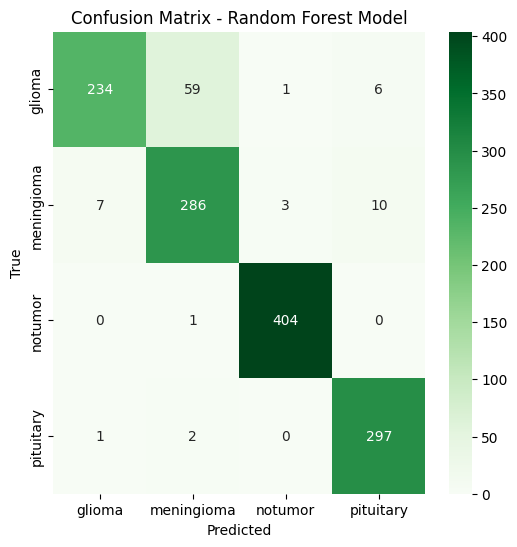

✅ Random Forest Test Accuracy: 93.14%


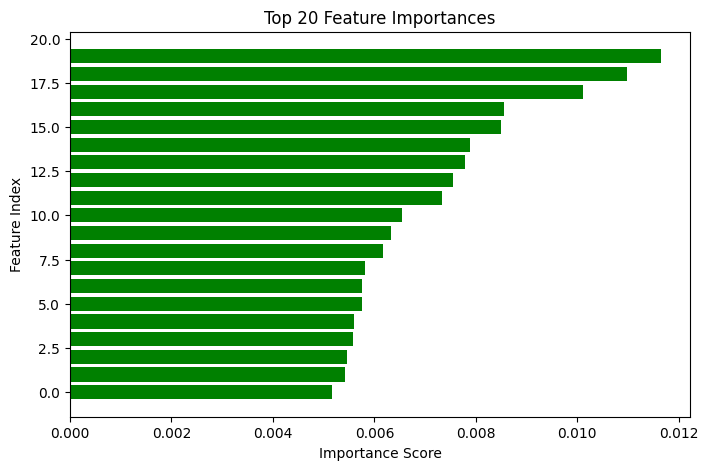


💾 Model saved successfully in /results/models/


In [ ]:
# ============================================================
# 🌲 Brain Tumor Classification using Random Forest + CNN Feature Extraction
# Author: [Your Name] - IT20210104
# ============================================================

# Step 1: Import Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib



!git clone https://github.com/Raashidh-Rizvi/Brain-Tumor-Detection.git


train_dir = "/content/Brain-Tumor-Detection/data/Training"
test_dir = "/content/Brain-Tumor-Detection/data/Testing"


print("✅ TensorFlow Version:", tf.__version__)

# Step 2: Define Dataset Paths
train_dir = "/content/Brain-Tumor-Detection/data/Training"
test_dir = "/content/Brain-Tumor-Detection/data/Testing"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Step 3: Image Preprocessing
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Step 4: Feature Extraction using Pretrained EfficientNetB0
print("\n🔍 Extracting features using EfficientNetB0...")

base_model = EfficientNetB0(weights="imagenet", include_top=False, pooling="avg")

X_train = base_model.predict(train_generator, verbose=1)
X_test = base_model.predict(test_generator, verbose=1)

y_train = train_generator.classes
y_test = test_generator.classes

print(f"✅ Feature extraction complete. Feature shape: {X_train.shape}")

# Step 5: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train Random Forest Classifier
print("\n🌲 Training Random Forest Classifier...")
rf_clf = RandomForestClassifier(
    n_estimators=200,       # number of trees
    max_depth=15,           # limit tree depth
    random_state=42,
    n_jobs=-1               # use all CPU cores
)
rf_clf.fit(X_train_scaled, y_train)

# Step 7: Predictions
y_pred = rf_clf.predict(X_test_scaled)

# Step 8: Evaluation Metrics
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=list(test_generator.class_indices.keys())))

# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.title("Confusion Matrix - Random Forest Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Step 10: Model Accuracy
accuracy = np.mean(y_pred == y_test)
print(f"✅ Random Forest Test Accuracy: {accuracy*100:.2f}%")

# Step 11: Feature Importance Visualization
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[-20:]  # top 20 features

plt.figure(figsize=(8,5))
plt.barh(range(len(indices)), importances[indices], color='green', align='center')
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature Index")
plt.show()

# Step 12: Save Model & Scaler
os.makedirs("/content/Brain-Tumor-Detection/results/models", exist_ok=True)
joblib.dump(rf_clf, "/content/Brain-Tumor-Detection/results/models/RandomForest_Model.pkl")
joblib.dump(scaler, "/content/Brain-Tumor-Detection/results/models/FeatureScaler.pkl")

print("\n💾 Model saved successfully in /results/models/")
